In [3]:
# Importing necessary libraries 

import numpy as np
import matplotlib.pyplot as plt

from numba import njit

### Casting the given equations into a suitable form

#### Given Kepler Orbit Equation to solve - 
$$ \frac{d^2 \vec{r}}{dt^2} = - \frac{G M_0}{r^3} \vec{r} $$

This is a second order ODE, where $\vec{r}$ is the position vector of the spacecraft, $M_0$ is the mass of the Earth and $G$ is the Universal Gravitation Constant (both known constants). To integrate this equation numerically, we first break it down into **two coupled first-order ODEs** as follows -  

\begin{equation}
\frac{d \vec{r}}{dt} = \vec{v}, \hspace{7mm}  \frac{d \vec{v}}{dt} = - \frac{G M_0}{r^3} \vec{r} 
\end{equation}

Now, since $ \vec{r}, \vec{v}$ are 2D vector quantities, we break these equations down into their separate cartesian components as follows -
\begin{equation}
\frac{d \vec{r}}{dt} = \vec{v} \implies \frac{dx}{dt} = v_x, \hspace{3mm} \frac{dy}{dt} = v_y
\begin{equation}
$ \frac{d \vec{v}}{dt} = - \frac{G M_0}{r^3} \vec{r} \implies \frac{dv_x}{dt} = a_x = - \frac{G M_0}{r^3}x, \hspace{3mm} \frac{dv_y}{dt} = a_y = - \frac{G M_0}{r^3}y$ where $r = \sqrt{x^2 + y^2}$.

We thus define an acceleration function based on our expressions for $\frac{d\vec{v}}{dt}$ and use that in our numerical integration scheme. The values of constants $G, M_0$ are known but of very different orders of magnitudes. To avoid any numerical error while multiplying these to evaluate the acceleration at every step, we directly supply the pre-calculated value of $GM_0$ as a constant, which is obtained by the following - 
$$ G = 6.674 \times 10^{-11} \text{ m}^3/ \text{kg s}^2 = 6.674 \times 10^{-20} \text{ km}^3/\text{kg s}^2 $$
Since we're dealing with distances in kilometers, we use the value of $G$ in the above unit, and calculate the value of $GM_0$ as follows - $$ G * M_0 = (6.674 \times 10^{-20}) * (5.972 \times 10^{24}) \approx 398571 \text{ km}^3/\text{kg s}^2  $$

Thus, we assign this value directly to the $GM_0$ parameter in our acceleration functin, and use it to compute the acceleration at every time step of the integration, as follows - 

In [4]:
# Defining acceleration (dv/dt) function
@njit 
def dvdt(x,y):
    """
    Uses position coordinates (x,y) at any point in the trajectory to calculate the acceleration of the spacecraft 
    using the given equations for a Keplerian Orbit, decomposed into first-order ODEs, as illustrated above. 

    Returns the acceleration vector components (ax, ay).
    """
    
    GM = 398571.0                  # calculated value of G*M_0 (gravitational parameter)

    r = np.sqrt(x**2 + y**2)       # radius at that point
 
    ax = (-GM*x)/r**3              # x-component of acceleration
    ay = (-GM*y)/r**3              # y-component of acceleration

    return ax, ay                  # return both components


# Defining RK4 integrator
@njit
def rk4_order2(f, h, x0, y0, vx0, vy0, T):
    """
    Uses the Runge-Kutta 4 numerical integration scheme to integrate a given (acceleration) function 'f' from 
    initial position (x0, y0) and velocity (vx0, vy0) till time 'T', in steps of 'h'.

    Returns (x,y) position coordinates at every timestep of the integration, along with the 'n' - the number of 
    integration steps taken.
    """
    # Defining number of steps of integration
    n = int(T/h)

    # Creating time, position, and velocity arrays to store the positions and velocities at every timestep
    t, x, y, vx, vy = np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)

    # Initializing position arrays with given initial positions
    x[0], y[0] = x0, y0

    # Initializing velocities with given initial velocity components
    vx[0], vy[0] = vx0, vy0

    # Integration loop
    for i in range(n):
        # Storing current position
        x_i = x[i]
        y_i = y[i]

        # Calculating accelerations at current position (starting of integration step): k1
        ax1, ay1 = f(x_i, y_i)
        k1x = h * vx[i]
        k1y = h * vy[i]
        k1vx = h * ax1
        k1vy = h * ay1

        # Calculating accelerations for k2 (midpoint) 
        ax2, ay2 = f(x_i + k1x/2, y_i + k1y/2)
        k2x = h * (vx[i] + k1vx/2)
        k2y = h * (vy[i] + k1vy/2)
        k2vx = h * ax2
        k2vy = h * ay2

        # Calculating accelerations for k3 (midpoint)
        ax3, ay3 = f(x_i + k2x/2, y_i + k2y/2)
        k3x = h * (vx[i] + k2vx/2)
        k3y = h * (vy[i] + k2vy/2)
        k3vx = h * ax3
        k3vy = h * ay3

        # Calculating accelerations for endpoint of integration step
        ax4, ay4 = f(x_i + k3x, y_i + k3y)
        k4x = h * (vx[i] + k3vx)
        k4y = h * (vy[i] + k3vy)
        k4vx = h * ax4
        k4vy = h * ay4

        # Updating position arrays with the correct RK-4 weights
        x[i+1] = x[i] + (k1x + 2*k2x + 2*k3x + k4x) / 6
        y[i+1] = y[i] + (k1y + 2*k2y + 2*k3y + k4y) / 6

         # Updating velocity values with the correct RK-4 weights
        vx[i+1] = vx[i] + (k1vx + 2*k2vx + 2*k3vx + k4vx) / 6
        vy[i+1] = vy[i] + (k1vy + 2*k2vy + 2*k3vy + k4vy) / 6

    
    return x, y, vx, vy, n       # return the position coordinates, velocity components and number of timesteps taken


This defines our acceleration as well as numerical integration function. We now put in the appropriate initial conditions given in the question and evolve our spacecraft's trajectory for a physically reasonable step-size $h$ and integration time $T$ as follows - 

In [5]:
 # Initial conditions for a spacecraft at perigee
earth_radius = 6378.0     # Earth's radius in km (given)
perigee_alt = 300.0       # km above Earth's surface

# Starting at perigee along the x-axis
x0 = earth_radius + perigee_alt  
y0 = 0.0                         

# Initial velocity (tangential at perigee)
velocity_perigee = 9  # given value in km/s
vx0 = 0.0  
vy0 = velocity_perigee  # at chosen perigee position, the velocity vector will point in the +y direction

# Time parameters
h = 5.0  # Time step in seconds
T = 4e4  # Total time in seconds

# Integrate the orbit and get the full trajectory
x_vals, y_vals, vx_vals, vy_vals, n = rk4_order2(dvdt, h, x0, y0, vx0, vy0, T)



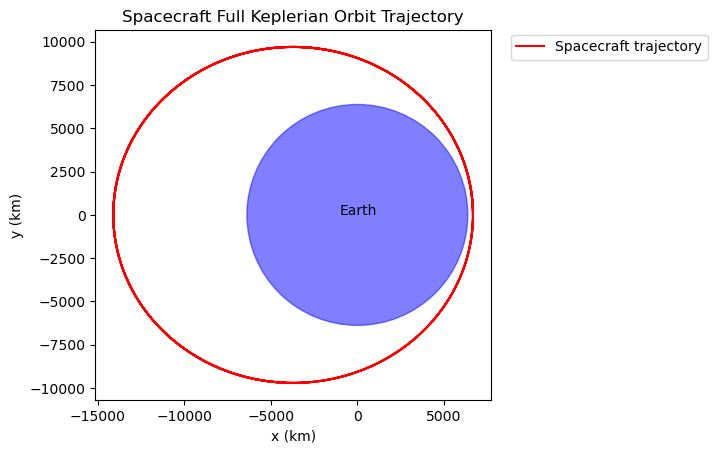

In [6]:
## Plotting
fig, ax = plt.subplots()

# Creating a circular patch representing the Earth
earth = plt.Circle((0, 0), radius=6378.0, color='blue', alpha=0.5)  # alpha for transparency
ax.add_patch(earth)
ax.text(-1000, 0, 'Earth')

# Plotting the orbit trajectory
ax.plot(x_vals, y_vals, color='red', label="Spacecraft trajectory")
ax.legend(loc = (1.05, 0.92))

# Setting the aspect ratio of the plot to be equal
ax.set_aspect('equal')

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
plt.title('Spacecraft Full Keplerian Orbit Trajectory')
plt.show()


### Finding apogee altitude and orbital time period

To find both these quantities, we use the obtained position coordinates $(x,y)$ for each timestep to calculate the radius $r$ of the orbit (distance from the origin, which is the center of the earth), and plot its variation with time to observe its periodicity and determine the apogee altitude from the local maxima(e) of this function and the orbital time period from the period of this function, as follows - 

In [7]:
# computing distance from center of earth 
r = np.sqrt(x_vals**2 + y_vals**2) 

# computing altitude of spacecraft from surface of the earth
alt = r - earth_radius

# Generating a time array identical to the one used in the integration
t = np.linspace(0,T, n+1)

Plotting distance $r$ as a function of time $t$ 

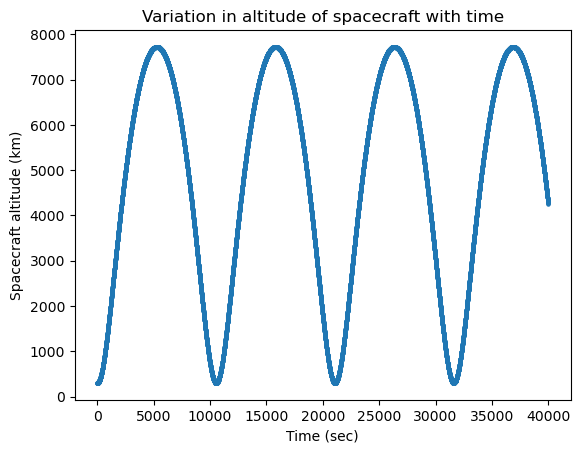

In [8]:
plt.scatter(t, alt, s=5)
plt.title("Variation in altitude of spacecraft with time")
plt.xlabel("Time (sec)")
plt.ylabel("Spacecraft altitude (km)");

We can see that this function has a periodic behavior, as expected. The maximae represent the apogees, while the minimae represent the perigees. We write two simple functions going over the entire altitude array and comparing every element with its immediate neighbours to filter out peaks, dips and their indices (locations in the array) as follows -

In [9]:
@njit
def find_peaks(array):
    peaks = []
    # For all points in the array except first and last points, 
    for i in range(1, len(array) - 1):
        # If the current element is greater than its neighbors
        if array[i] > array[i - 1] and array[i] > array[i + 1]:
            peaks.append(i)  # Then store the index of the peak
            
    return np.array(peaks)

@njit
def find_dips(array):
    dips = []
    # For all points in the array except first and last points, 
    for i in range(1, len(array) - 1):
        # If the current element is smaller than its neighbors
        if array[i] <array[i - 1] and array[i] < array[i + 1]:
            dips.append(i)  # Then store the index of the dip
            
    return np.array(dips)



In [10]:
# Applying our written function to the altitude data
peaks = find_peaks(alt)
dips  = find_dips(alt)

# Printing values to check first
print(peaks, dips)

[1054 3161 5269 7376] [2107 4215 6322]


We now visually verify that our functions to find peaks and dips work, by plotting vertical lines at the indices they have found, as follows - 

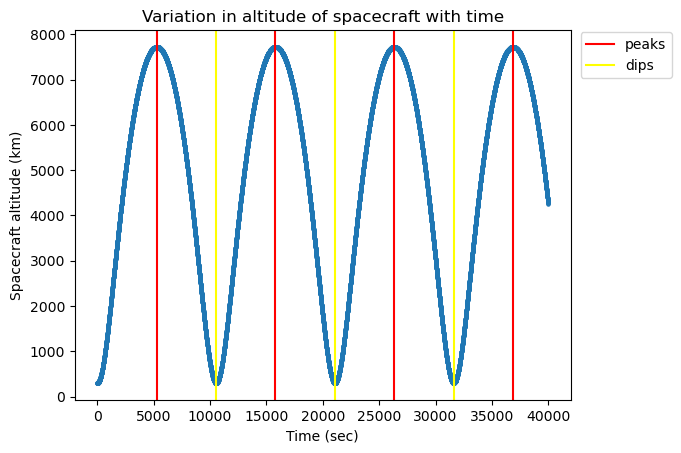

In [11]:
plt.axvline(t[peaks][0], color='red', label='peaks')
plt.axvline(t[peaks][1], color='red')
plt.axvline(t[peaks][2], color='red')
plt.axvline(t[peaks][3], color='red')
plt.axvline(t[dips][0], color='yellow', label="dips")
plt.axvline(t[dips][1], color='yellow')
plt.axvline(t[dips][2], color='yellow')
plt.legend(loc=(1.02, 0.87))

plt.scatter(t, alt, s=5)
plt.title("Variation in altitude of spacecraft with time")
plt.xlabel("Time (sec)")
plt.ylabel("Spacecraft altitude (km)");

Having verified that these work, we now find the maximum altitudes and the period of the above function by averaging over all of the above data. Using these, we calculate the average apogee altitude and orbital time period in hours as follows -

In [12]:
max_alts = np.array([ alt[i] for i in peaks ]) 
dip_times  = np.array([ t[i] for i in dips ])

periods = np.zeros(len(dip_times))
periods[0] = dip_times[0]

for i in range(1, len(dip_times)):
    periods[i] = dip_times[i] - dip_times[i-1]


avg_apogee = np.round(np.mean(max_alts), 3)
avg_timeperiod = np.round(np.mean(periods), 5)
avg_timeperiod_hours = np.round(np.mean(periods)/3600, 3)

mins = int( (  (avg_timeperiod_hours - int(avg_timeperiod_hours)  )*3600) / 60 )

print(f"Average apogee altitude is {avg_apogee} kms.")
print(f"Average orbital time period is {avg_timeperiod_hours} hours, or approximately {int(avg_timeperiod_hours)} hours {mins} minutes.")
print(f"Average time period in seconds is {np.round(avg_timeperiod,5)} seconds")

Average apogee altitude is 7720.017 kms.
Average orbital time period is 2.927 hours, or approximately 2 hours 55 minutes.
Average time period in seconds is 10536.66667 seconds


### 10000 Orbital Periods

We now run the integration for 10000 orbital periods, using the average orbital period value found above, still using the RK4 scheme. We also record the time it takes.

In [13]:
%%time 

New_T = avg_timeperiod*1e4
x_rk4, y_rk4, vx_rk4, vy_rk4, n = rk4_order2(dvdt, h, x0, y0, vx0, vy0, New_T)

CPU times: user 972 ms, sys: 214 ms, total: 1.19 s
Wall time: 1.17 s


### Computing Total Energy and Momentum of Orbit

The total energy of the orbit at each time-step is given by the sum of the potential and kinetic energies of the orbit at that time step. We use the following standard expressions for calculating these quantities - 
$$ K.E. = \frac{1}{2} m v^2 = \frac{1}{2} m (v_x^2 + v_y^2), \hspace{5mm} P.E. = - \frac{GmM_0}{r} = - \frac{GmM_0}{\sqrt{x^2 + y^2}}$$

The expression for computing the angular momentum of the spacecraft in orbit is given by - 
$$ \vec{L} = \vec{r} \times \vec{p} = \vec{r} \times m\vec{v}  $$
Now, since we haven't been given the value of $m$, the mass of the spacecraft, we work with both kinetic and potential energies, as well as angular momentum,*per unit mass of spacecraft* instead. For all practical purposes, this has no effect on the analysis and interpretations in this problem. Thus, we instead have - 
$$ \text{ Total Energy per unit mass} = \text{ K.E. per unit mass} + \text{P.E. per unit mass} $$
$$ \implies T.E. = \frac{1}{2}(v_x^2 + v_y^2) - \frac{GM_0}{\sqrt{x^2 + y^2}} $$
$$ \text{ Angular momentum per unit mass} = L = \vec{r} \times \vec{v} $$

Using the above expression(s) we calculate the total energy and angular momentum of the orbit per unit mass and plot it's variation with time as follows - 

In [14]:
@njit
def TE_mass (x,y, vx, vy): 
    """
    Outputs the total energy of the system using given position coordinates and velocity components.
    """
    # Calculating magnitude of velocity squared at each timestep
    v_sq = vx**2 + vy**2 
    
    # Computing kinetic energy per unit mass of spacecraft
    KE_m = 0.5*v_sq
    
    # Redefining GM value for potential energy
    GM = 398571.0
    
    # Calculating radial distance from center of earth for PE
    r = np.sqrt(x**2 + y**2)
    
    # Computing potential energy per unit mass of spacecraft at each timestep
    PE_m = - GM / r
    
    # Adding KE and PE to compute Total energy TE per unit mass of spacecraft at each timestep
    TE_m = PE_m + KE_m

    return TE_m   # return calculated energy value


def L_mass(x,y,vx,vy):
    """
    Outputs the angular momentum of the system using given position coordinates and velocity components.
    """
    # Converting to 2D arrays for cross product
    r = np.array([x,y])
    v = np.array([vx,vy])
    
    # Computing angular momentum per unit mass of spacecraft
    L_m = np.cross(r, v)

    return L_m      # returns a number since our inputs are 2x2 vectors
    
# Generating a time array identical to the one used in the integration
t = np.linspace(0,New_T, n+1)


#### Plotting % change in total energy with time

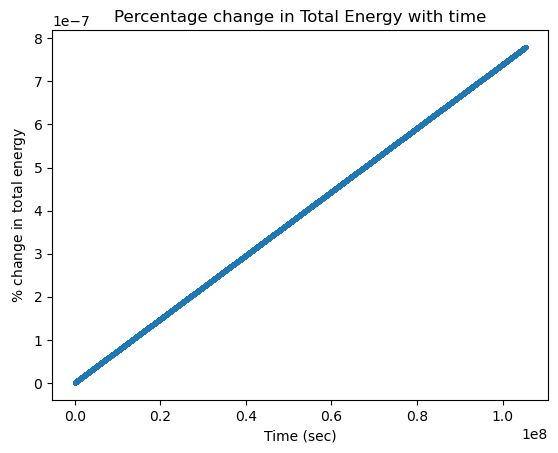

In [15]:
TE_m = TE_mass(x_rk4, y_rk4, vx_rk4, vy_rk4)
TE_init = TE_m[0]
TE_change = TE_m - TE_init
TE_percent_change = (TE_change/TE_init)*100

plt.scatter(t, TE_percent_change, s=2)
plt.title("Percentage change in Total Energy with time")
plt.ylabel(r"$\%$ change in total energy")
plt.xlabel("Time (sec)");

We observe that for these particular integration parameters (step size = 5 sec), the percentage change in total energy is negligible even when running for 10000 orbital time periods, of the order of $10^{-7}$. We now check the % change in angular momentum for the system, with the same approach - 

In [16]:
%%time 

L_m = np.zeros(len(x_rk4))
for i in range(len(x_rk4)):
    L_m[i] = L_mass(x_rk4[i], y_rk4[i], vx_rk4[i], vy_rk4[i])

CPU times: user 3min 38s, sys: 2.25 s, total: 3min 40s
Wall time: 3min 38s


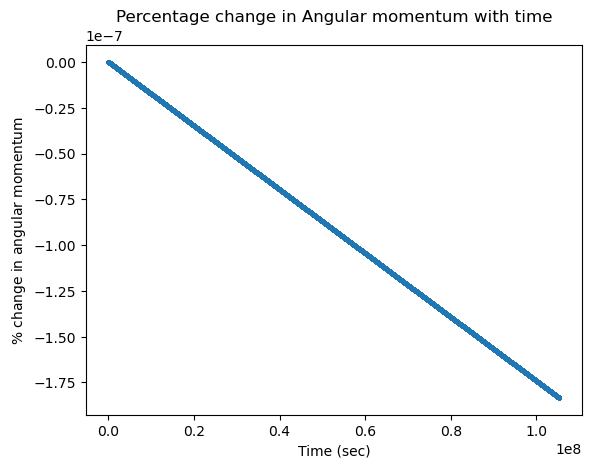

In [17]:
L_init = L_m[0] 
L_change = L_m - L_init
L_percent_change = (L_change/L_init)*100

plt.scatter(t, L_percent_change, s=2)
plt.title("Percentage change in Angular momentum with time")
plt.ylabel(r"$\%$ change in angular momentum")
plt.xlabel("Time (sec)");

The scale on the y-axis of the above graph tells us that the percentage change in angular momentum of the orbit is also quite negligible, for this step-size.

### Adaptive step-size control

To find out a better (larger in this case) value of step-size $h$ to use such that the angular momentum error remains under 0.1% and the integration happens faster, we first evolve the system for time $T$ = 10000 orbital periods using our first $h$ value (as done above). Then we halve the step-size, (doubling the total number of time steps) and run it for the same amount of integration time. 

We compute both angular momentum and total energy of systems for both runs, and find the difference between them. This is our $\Delta$. We then set $\Delta_0 = 0.01 %$ and find our new $h$ value for the error to stay under $\Delta_0$ by - 
$$ h_{\text{new}} = h_{\text{old}} \times \left( \frac{\Delta_0}{\Delta} \right)^{1/5} $$

This new $h$ value should keep our errors under $\Delta_0$, and be fifth-order accurate.

In [18]:
# Modifying step size to be half the initial h
h_2 = h/2

h_2

2.5

In [19]:
%%time

# Now running rk4 integration with 2x number of steps and half the step size to calculate delta
x2_rk4, y2_rk4, vx2_rk4, vy2_rk4, n2 = rk4_order2(dvdt, h_2, x0, y0, vx0, vy0, New_T)

CPU times: user 1.93 s, sys: 385 ms, total: 2.32 s
Wall time: 2.3 s


In [20]:
n/n2     # should be (1/2)= 0.5

0.5

We now calculate $\Delta$ using Total energy values (since its percentage change is marginally higher compared to angular momentum) obtained from the $h$ and $h/2$ runs, and take the difference. Since the resultant $\Delta$ is a time series with errors adding up and maximizing towards the end, we define our actual value of the $\Delta$ to be the difference between the *last* values of total energy, of both runs. We now calculate this $\Delta$ - 

In [21]:
%%time 

# Evaluating total energy time series for the h/2 run
TE_h_2 = TE_mass(x2_rk4, y2_rk4, vx2_rk4, vy2_rk4)

CPU times: user 249 ms, sys: 345 ms, total: 594 ms
Wall time: 588 ms


In [22]:
# defining and finding value of delta as the difference of L values between h and h/2 runs
delta = np.abs(TE_m[-1] - TE_h_2[-1])
delta

1.4496217559667457e-07

In [23]:
delta_0 = 0.01              # 0.1% = 0.001, but we find that even this value of delta_0 keeps the error under limits

frac = (delta_0 / delta)**(0.2)

h_new = h*frac

h_new

46.421488791817616

We now need to find the average time period associated with this new step size, so as to integrate over 10000 orbital periods and show that the new error is just under 0.1%.

In [24]:
# Time parameters
h = h_new   # Time step in seconds
T = 4e4  # Total time in seconds

# Integrate the orbit and get the full trajectory
x_new, y_new, vx_new, vy_new, n3 = rk4_order2(dvdt, h_new, x0, y0, vx0, vy0, T)


In [25]:
# computing distance from center of earth 
r = np.sqrt(x_new**2 + y_new**2) 

# computing altitude of spacecraft from surface of the earth
alt = r - earth_radius

# Generating a time array identical to the one used in the integration
t = np.linspace(0,T, n3+1)

# Applying our written function to the altitude data
peaks = find_peaks(alt)
dips  = find_dips(alt)

In [26]:
max_alts = np.array([ alt[i] for i in peaks ]) 
dip_times  = np.array([ t[i] for i in dips ])

periods = np.zeros(len(dip_times))
periods[0] = dip_times[0]

for i in range(1, len(dip_times)):
    periods[i] = dip_times[i] - dip_times[i-1]


avg_apogee = np.round(np.mean(max_alts), 3)
avg_timeperiod = np.round(np.mean(periods), 8)

print(f"For new stepsize, the average value of time period of orbit is {np.round(avg_timeperiod,5)} seconds.")

For new stepsize, the average value of time period of orbit is 10545.87689 seconds.


In [27]:
h_new

46.421488791817616

We now use this value and multiply it by 10000 to calculate the complete integration time for this new stepsize, and do the integration as follows - 

In [28]:
%%time 

h_new_T_new = avg_timeperiod*1e4
x_new_rk4, y_new_rk4, vx_new_rk4, vy_new_rk4, n_new = rk4_order2(dvdt, h_new, x0, y0, vx0, vy0, h_new_T_new)

CPU times: user 118 ms, sys: 24.1 ms, total: 142 ms
Wall time: 141 ms


In [29]:
# Generating a time array identical to the one used in the above integration
t_new = np.linspace(0, h_new_T_new, n_new+1)


In [30]:
TE_m_new = TE_mass(x_new_rk4, y_new_rk4, vx_new_rk4, vy_new_rk4)
TE_init_new = TE_m_new[0]
TE_change_new = TE_m_new - TE_init_new
TE_percent_change_new = (TE_change_new/TE_init_new)*100



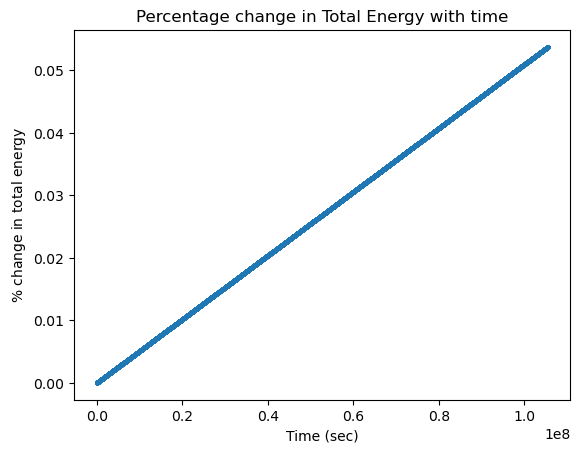

In [31]:
plt.scatter(t_new, TE_percent_change_new, s=2)
plt.title("Percentage change in Total Energy with time")
plt.ylabel(r"$\%$ change in total energy")
plt.xlabel("Time (sec)");

We can see that our percentage error in total energy is now just less (same order of magnitude) than the desired **0.1%**, with a *much higher* value of step-size $h$, translating to much faster integration

In [32]:
%%time 
L_m_new = np.zeros(len(x_new_rk4))
for i in range(len(x_new_rk4)):
    L_m_new[i] = L_mass(x_new_rk4[i], y_new_rk4[i], vx_new_rk4[i], vy_new_rk4[i])


L_init_new = L_m_new[0]
L_change_new = L_m_new - L_init_new
L_percent_change_new = (L_change_new/L_init_new)*100

CPU times: user 23.1 s, sys: 414 ms, total: 23.5 s
Wall time: 23.1 s


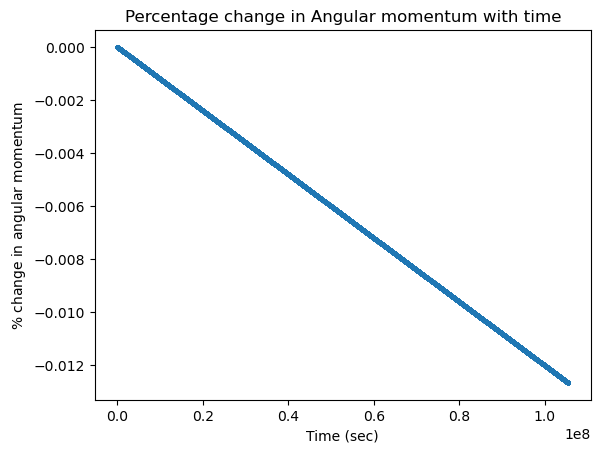

In [33]:
plt.scatter(t_new, L_percent_change_new, s=2)
plt.title("Percentage change in Angular momentum with time")
plt.ylabel(r"$\%$ change in angular momentum")
plt.xlabel("Time (sec)");

We can see a similar result for the angular momentum variation as well, whose error has increased from the initial value to now come closer to our required tolerance value, but with faster integration time. (Thought it is still quite smaller than the required error value, but we are more constrained by the percentage error in the **total energy** of the system, rather than the angular momentum, and so we stick to this.

### Comparison with Euler Integration

Having done the above analysis using the Runge-Kutta 4 numerical integration scheme, we now do the same analysis using an explicit Eulerian integration scheme -

In [34]:
@njit
def euler_order2(f, h, x0, y0, vx0, vy0, T):
    # Number of steps
    n = int(T/h)   
    
   # Creating time, position, and velocity arrays to store the positions and velocities at every timestep
    t, x, y, vx, vy = np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)

    # Initializing position arrays with given initial positions
    x[0], y[0] = x0, y0

    # Initializing velocities with given initial velocity components
    vx[0], vy[0] = vx0, vy0

    # Integration loop
    for i in range(n):
        # Storing current position
        x_i = x[i]
        y_i = y[i]
        
        # Calculating accelerations at the current position
        ax, ay = f(x_i, y_i)
        
        # Updating position arrays using the Euler method
        x[i + 1] = x[i] + h * vx[i]
        y[i + 1] = y[i] + h * vy[i]

        # Updating velocity values using the Euler method
        vx[i + 1] = vx[i] + h * ax
        vy[i + 1] = vy[i] + h * ay

    return x, y, vx, vy, n 

We now use the exact same initial conditions and integration parameters to run evolve the system under an Eulerian scheme, and compare our results to the RK4 scheme-

In [35]:
# Time parameters
h = 5.0  # Time step in seconds
T = 4e4  # Total time in seconds

In [36]:
# Integrate the orbit and get the full trajectory
x_vals_eul, y_vals_eul, vx_vals_eul, vy_vals_eul, n_eul = euler_order2(dvdt, h, x0, y0, vx0, vy0, T)

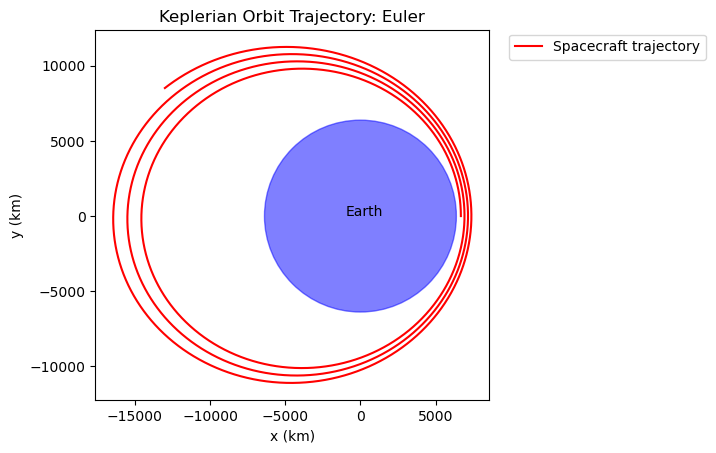

In [37]:
## Plotting
fig, ax = plt.subplots()

# Creating a circular patch representing the Earth
earth = plt.Circle((0, 0), radius=6378.0, color='blue', alpha=0.5)  # alpha for transparency
ax.add_patch(earth)
ax.text(-1000, 0, 'Earth')

# Plotting the orbit trajectory
ax.plot(x_vals_eul, y_vals_eul, color='red', label="Spacecraft trajectory")
ax.legend(loc = (1.05, 0.92))

# Setting the aspect ratio of the plot to be equal
ax.set_aspect('equal')

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
plt.title('Keplerian Orbit Trajectory: Euler')
plt.show()


From the above graph we can already see the unstable nature of Explicit Euler, since the errors have already started adding up significantly enough for us to observe them visually in the first few orbits itself. We now compute the average time period for this Eulerian trajectory -

In [38]:
# computing distance from center of earth 
r = np.sqrt(x_vals_eul**2 + y_vals_eul**2) 

# computing altitude of spacecraft from surface of the earth
alt = r - earth_radius

# Generating a time array identical to the one used in the integration
t = np.linspace(0,T, n_eul+1)

peaks = find_peaks(alt)
dips  = find_dips(alt)

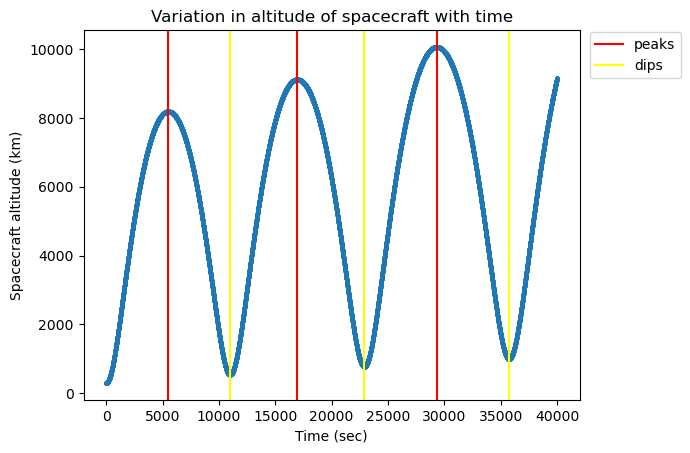

In [39]:
plt.axvline(t[peaks][0], color='red', label='peaks')
plt.axvline(t[peaks][1], color='red')
plt.axvline(t[peaks][2], color='red')
# plt.axvline(t[peaks][3], color='red')
plt.axvline(t[dips][0], color='yellow', label="dips")
plt.axvline(t[dips][1], color='yellow')
plt.axvline(t[dips][2], color='yellow')
plt.legend(loc=(1.02, 0.87))

plt.scatter(t, alt, s=5)
plt.title("Variation in altitude of spacecraft with time")
plt.xlabel("Time (sec)")
plt.ylabel("Spacecraft altitude (km)");

In [40]:
max_alts = np.array([ alt[i] for i in peaks ]) 
dip_times  = np.array([ t[i] for i in dips ])

periods = np.zeros(len(dip_times))
periods[0] = dip_times[0]

for i in range(1, len(dip_times)):
    periods[i] = dip_times[i] - dip_times[i-1]


avg_apogee = np.round(np.mean(max_alts), 3)
avg_timeperiod = np.round(np.mean(periods), 5)
avg_timeperiod_hours = np.round(np.mean(periods)/3600, 3)

mins = int( (  (avg_timeperiod_hours - int(avg_timeperiod_hours)  )*3600) / 60 )

print(f"Average apogee altitude from Euler with h=5sec is {avg_apogee} kms.")
print(f"Average orbital time period from Euler with h=5sec is {avg_timeperiod_hours} hours, or approximately {int(avg_timeperiod_hours)} hours {mins} minutes.")
print(f"Average time period in seconds is {np.round(avg_timeperiod,5)} seconds")

Average apogee altitude from Euler with h=5sec is 9123.783 kms.
Average orbital time period from Euler with h=5sec is 3.309 hours, or approximately 3 hours 18 minutes.
Average time period in seconds is 11911.66667 seconds


This value of average time period is already quite different (higher) than the value of average time period obtained from RK4 integration, which was roughly **2hrs 55 mins**

In [41]:
print(periods)

[10985. 11905. 12845.]


The above values tell us the time periods, in seconds, calculated using the "dips" in the Altitude vs Time plot for Euler (shown above). The magnitude of variation in these numbers also already shows us the unstable nature of Explicit Euler. 

Now, using the average time period value obtained, we run euler for 10000 orbital periods and see its energy and angular momentum variation (percentage change) with time, to compare against RK4 with identical integration parameters -

In [42]:
%%time 

New_T_eul = avg_timeperiod*1e4
x_eul1, y_eul1, vx_eul1, vy_eul1, n_eul1 = euler_order2(dvdt, h, x0, y0, vx0, vy0, New_T_eul)

CPU times: user 264 ms, sys: 209 ms, total: 473 ms
Wall time: 470 ms


Euler ran in 563 milli seconds, which is roughly a little less than 1/2 the time RK4 took to run for the same integration parameters (roughly 1.2 seconds).
Even though these run-times are all scaled down by our use of njit for faster compile time, they are all scaled down by the same amount, and thus, we can still proportionally analyse and comment upon the relative difference in the run times of our integration schemes.

To analyse Euler's stability, we also now plot the $\%$ variation in total energy and angular momentum from the above run to compare it with RK4 -

-19.18418688230009

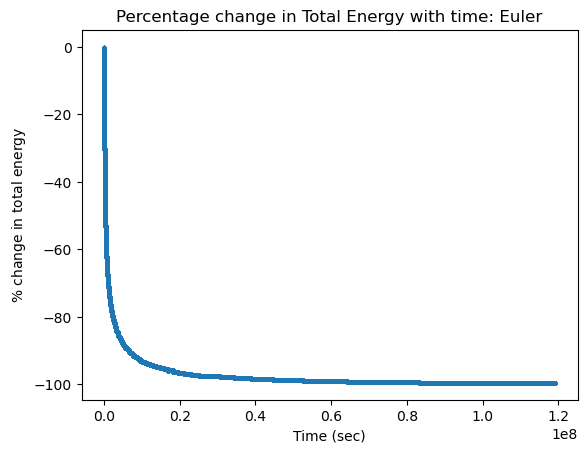

In [43]:
# Generating a time array identical to the one used in the above integration
t_eul1 = np.linspace(0, New_T_eul, n_eul1+1)

# Calculating percentage change in energy over all the timesteps
TE_m_eul = TE_mass(x_eul1, y_eul1, vx_eul1, vy_eul1)
TE_init_eul = TE_m_eul[0]
TE_change_eul = TE_m_eul - TE_init_eul
TE_percent_change_eul = (TE_change_eul/TE_init_eul)*100


plt.scatter(t_eul1, TE_percent_change_eul, s=2)
plt.title("Percentage change in Total Energy with time: Euler")
plt.ylabel(r"$\%$ change in total energy")
plt.xlabel("Time (sec)");

TE_init

This shows that this Euler integration is doing very poorly in terms of conserving the system's total energy, which further highlights to use the unstable nature of this method.

In [44]:
%%time

L_m_eul1 = np.zeros(len(x_eul1))
for i in range(len(x_eul1)):
    L_m_eul1[i] = L_mass(x_eul1[i], y_eul1[i], vx_eul1[i], vy_eul1[i])



L_init_eul1 = L_m_eul1[0]
L_change_eul1 = L_m_eul1 - L_init_eul1
L_percent_change_eul1= (L_change_eul1/L_init_eul1)*100

CPU times: user 4min 9s, sys: 5.19 s, total: 4min 14s
Wall time: 4min 8s


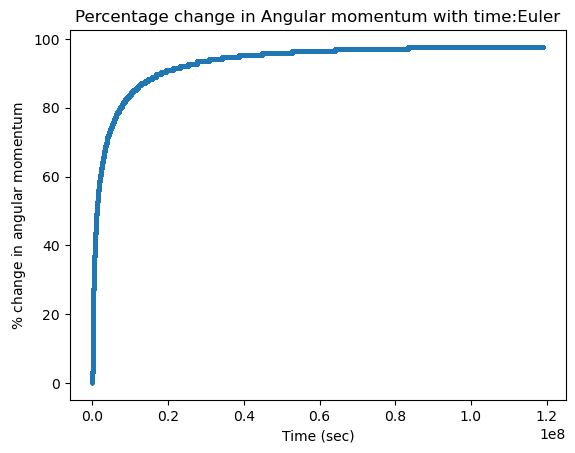

In [45]:
plt.scatter(t_eul1, L_percent_change_eul1, s=2)
plt.title("Percentage change in Angular momentum with time:Euler")
plt.ylabel(r"$\%$ change in angular momentum")
plt.xlabel("Time (sec)");

We ran Euler integration for largely the same initial conditions as for RK4. We can see how largely unstable the Eulerian scheme is compared to RK4 for identical integration parameters. The only advantage is that Euler runs much faster than RK4. But the variation consecutive time periods, percentage change in total energy and angular momentum for runs over 10000 orbital periods, all shows us the very unstable nature of the system. 

Anticipating that the explicit Euler will be unstable for values of $h$ greater than a certain value (dependent on the acceleration function), we now use a much smaller step-size of **h = 0.5** to evolve the system. Redefining the time parameters just in case they have converted to different values in some subsequent step -

In [46]:
%%time 
## Run euler for much smaller time steps

h2 = 1
x_eul2, y_eul2, vx_eul2, vy_eul2, n_eul2 = euler_order2(dvdt, h2, x0, y0, vx0, vy0, New_T_eul)

CPU times: user 1.55 s, sys: 984 ms, total: 2.53 s
Wall time: 2.52 s


In [ ]:
# Generating a time array identical to the one used in the above integration
t_eul2 = np.linspace(0, New_T_eul, n_eul2+1)

# Calculating percentage change in energy over all the timesteps
TE_m_eul = TE_mass(x_eul2, y_eul2, vx_eul2, vy_eul2)
TE_init_eul = TE_m_eul[0]
TE_change_eul = TE_m_eul - TE_init_eul
TE_percent_change_eul = (TE_change_eul/TE_init_eul)*100




In [ ]:
plt.scatter(t_eul2, TE_percent_change_eul, s=2)
plt.title("Percentage change in Total Energy with time: Euler")
plt.ylabel(r"$\%$ change in total energy")
plt.xlabel("Time (sec)");

TE_init

In [ ]:
L_m_eul1 = np.zeros(len(x_eul1))
for i in range(len(x_eul1)):
    L_m_eul1[i] = L_mass(x_eul1[i], y_eul1[i], vx_eul1[i], vy_eul1[i])



L_init_eul1 = L_m_eul1[0]
L_change_eul1 = L_m_eul1 - L_init_eul1
L_percent_change_eul1= (L_change_eul1/L_init_eul1)*100